In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass, asdict
import csv
import json
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Optional
from datetime import datetime
from main import sample_episode
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
# from scipy.special import theta
import numpy as np

# --- Jacobi theta3 helper: theta(3, z, q) ---
try:
    # If your SciPy has it, this will work in your environment
    from scipy.special import theta as _theta

    def theta3(z, q):
        # SciPy version: vectorized
        return _theta(3, z, q)

except Exception:
    # Fallback: mpmath (scalar; we convert to float)
    import mpmath as mp

    def theta3(z, q):
        return float(mp.jtheta(3, z, q))


def heat_kernel_S1(t, x, y, wrap=True):
    """
    Heat kernel on S^1 using theta3.
    x,y are angles in radians (typically in [0, 2π)).
    wrap=True wraps differences into (-π, π] for numerical stability.
    """
    d = x - y
    if wrap:
        d = (d + np.pi) % (2 * np.pi) - np.pi  # wrap to (-π, π]
    q = np.exp(-t)
    return (1 / (2 * np.pi)) * theta3(d / 2, q)


def heat_kernel_torus_2d(t, x_vec, y_vec, wrap=True):
    """
    Product kernel on S^1 x S^1 (2D torus).
    x_vec, y_vec are length-2 arrays: [angle1, angle2].
    """
    return heat_kernel_S1(t, x_vec[0], y_vec[0], wrap=wrap) * \
           heat_kernel_S1(t, x_vec[1], y_vec[1], wrap=wrap)

In [3]:
def gram_matrix_heat_torus_2d(X, t, wrap=True):
    """
    Build Gram matrix K where K[i,j] = heat_kernel_torus_2d(t, X[i], X[j]).
    X: shape (n, 2)
    """
    X = np.asarray(X, dtype=float)
    if X.ndim != 2 or X.shape[1] != 2:
        raise ValueError("X must have shape (n, 2) for 2D inputs.")

    n = X.shape[0]
    K = np.empty((n, n), dtype=float)

    # Fill symmetrically
    for i in range(n):
        for j in range(i, n):
            v = heat_kernel_torus_2d(t, X[i], X[j], wrap=wrap)
            K[i, j] = v
            K[j, i] = v
    return K


def solve_alphas(K, y, lam):
    """
    Solve (K + lam I) alpha = y without forming an explicit inverse.
    """
    K = np.asarray(K, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1)
    n = K.shape[0]
    if K.shape != (n, n):
        raise ValueError("K must be square.")
    if y.shape[0] != n:
        raise ValueError("y must have length n.")
    if lam <= 0:
        raise ValueError("lam should be > 0 for stable regularization.")

    # A = K + lam * np.eye(n)
    alpha = np.linalg.solve(K @ K + lam * K, K @ y)

    # # Cholesky is best when A is SPD (lam>0 typically ensures this)
    # try:
    #     L = np.linalg.cholesky(A)
    #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    # except np.linalg.LinAlgError:
    #     # Fallback if numerical issues arise
    #     alpha = np.linalg.solve(A, y)

    return alpha


def fit_kernel_machine_heat_torus(X, y, t, lam, wrap=True):
    """
    Convenience: compute Gram matrix + alpha.
    """
    K = gram_matrix_heat_torus_2d(X, t=t, wrap=wrap)
    alpha = solve_alphas(K, y, lam=lam)
    return K, alpha


def predict_heat_torus(X_train, alpha, X_test, t, wrap=True):
    """
    f(x) = sum_i alpha_i k(x, x_i)
    """
    X_train = np.asarray(X_train, dtype=float)
    X_test  = np.asarray(X_test, dtype=float)
    alpha   = np.asarray(alpha, dtype=float).reshape(-1)

    n = X_train.shape[0]
    if alpha.shape[0] != n:
        raise ValueError("alpha length must match number of training points.")

    yhat = np.empty(X_test.shape[0], dtype=float)
    for m, x in enumerate(X_test):
        s = 0.0
        for i in range(n):
            s += alpha[i] * heat_kernel_torus_2d(t, x, X_train[i], wrap=wrap)
        yhat[m] = s
    return yhat

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
p = torch.tensor([np.pi, np.pi], device=device)

In [5]:
def periodic_func(x,p):
    return np.cos(x[..., 0]) *(np.sin(x[..., 1])**2)

K_context:2   Mean error over 30 episodes: 1.4932140440736614 ± 0.9086575709961899
K_context:4   Mean error over 30 episodes: 0.9656631329929231 ± 0.8380100024447735


K_context:6   Mean error over 30 episodes: 0.731084143468654 ± 0.560640062763326
K_context:8   Mean error over 30 episodes: 0.9102414828174781 ± 0.7746435328361361
K_context:10   Mean error over 30 episodes: 0.9591511696450616 ± 0.7099265275412457
K_context:12   Mean error over 30 episodes: 0.6199813566877322 ± 0.6994056519496543
K_context:14   Mean error over 30 episodes: 0.3545292438739765 ± 0.34971624251210726
K_context:16   Mean error over 30 episodes: 0.32253330921483564 ± 0.32969158483203836
K_context:30   Mean error over 30 episodes: 0.12965597788438302 ± 0.12851738010485203
K_context:50   Mean error over 30 episodes: 0.11513413190892798 ± 0.15154017190915603
K_context:100   Mean error over 30 episodes: 0.2677021463437254 ± 0.43232897059342157


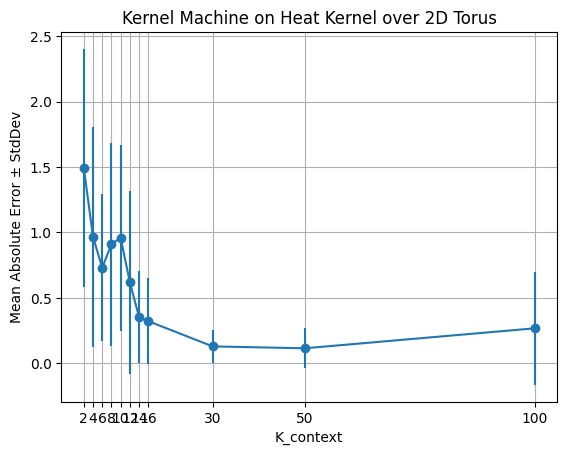

In [6]:
batch_size = 1
num_episodes = 30
means = np.array([])
stds = np.array([])
context_lengths = [2,4,6,8,10,12,14,16,30,50, 100]
for K_context in context_lengths:    
    this_vals = np.zeros(num_episodes)
    for rep in range(num_episodes):  # multiple samples to average over
        min = 100

        tokens, y_q = sample_episode(batch_size, K_context, p, device)
        # Test various (t_tilde, lam_tilde) combinations
        for t_tilde in [0.5]:
            for lam_tilde in [1e-8]:

                X = tokens.cpu().numpy()[0,0:K_context,0:2]  # (K,2)
                y = tokens.cpu().numpy()[0,0:K_context,2]  # (K,2)

                X_test = tokens.cpu().numpy()[0,-1:,0:2]
                # X_test = tokens.cpu().numpy()[0,0:1,0:2]
                try :
                    K, alpha = fit_kernel_machine_heat_torus(X, y, t=t_tilde, lam=lam_tilde)
                    y_pred = predict_heat_torus(X, alpha, X_test, t=t_tilde)
                    if np.abs(y_pred - y_q.cpu().numpy()) < min:
                        min = np.abs(y_pred - y_q.cpu().numpy())
                        min_t = t_tilde
                    # print(f"y_pred:{y_pred.item()}, y:{y_q.cpu().numpy()}, t_tilde:{t_tilde}, lam_tilde:{lam_tilde}   error {np.abs(y_pred - y_q.cpu().numpy())}")

                except np.linalg.LinAlgError:
                    pass
                    # print(f"LinAlgError for t_tilde:{t_tilde}, lam_tilde:{lam_tilde}")   
        # Keep track of minimum error across hyperparameters  
        # print(f"Minimum error achieved: {min}")
        this_vals[rep] = min[0]
    mean_error = np.mean(this_vals)
    std_error = np.std(this_vals)
    means = np.append(means, mean_error)
    stds = np.append(stds, std_error)
    print(f"K_context:{K_context}   Mean error over {num_episodes} episodes: {mean_error} ± {std_error}")
    
plt.errorbar(context_lengths, means, yerr=stds, fmt='-o')
plt.xlabel('K_context')
plt.ylabel('Mean Absolute Error ± StdDev')
plt.title('Kernel Machine on Heat Kernel over 2D Torus')
plt.xticks(context_lengths)
plt.grid(True)
plt.show()  

In [7]:
from scipy.spatial.distance import cdist
def SoftMaxKernel(X, t=1/2):
    real_X = np.column_stack([np.cos(X[...,0]), np.sin(X[...,0]), np.cos(X[...,1]), np.sin(X[...,1])])
    dist_mat =  cdist(real_X,real_X)**2
    exp_x = np.exp(-dist_mat/(4*t))
    return exp_x/np.sum(exp_x, axis=1)[:, np.newaxis]

def fit_kernel_machine_softmax(X, y, t, lam, wrap=True):
    """
    Convenience: compute Gram matrix + alpha.
    """
    K = SoftMaxKernel(X, t=t)
    alpha = solve_alphas(K, y, lam=lam)
    return K, alpha

In [8]:
def exp_dist_kernel(X, t=1/2):
    real_X = np.column_stack([np.cos(X[...,0]), np.sin(X[...,0]), np.cos(X[...,1]), np.sin(X[...,1])])
    dist_mat =  cdist(real_X,real_X)**2
    exp_x = np.exp(-dist_mat/(4*t))
    return exp_x

def fit_kernel_machine_exp(X, y, t, lam, wrap=True):
    """
    Convenience: compute Gram matrix + alpha.
    """
    K = exp_dist_kernel(X, t=t)
    alpha = solve_alphas(K, y, lam=lam)
    return K, alpha

In [9]:
def softmax_corr(X, t=1/2):
    real_X = np.column_stack([np.cos(X[...,0]), np.sin(X[...,0]), np.cos(X[...,1]), np.sin(X[...,1])])

    exp_x = np.exp(real_X @real_X.T/(t))
    return exp_x/np.sum(exp_x, axis=1)[:, np.newaxis]
def fit_kernel_machine_corr(X, y, t, lam, wrap=True):
    """
    Convenience: compute Gram matrix + alpha.
    """
    K = softmax_corr(X, t=t)
    alpha = solve_alphas(K, y, lam=lam)
    return K, alpha

In [10]:
import json

class BestConfigTracker:
    def __init__(self, save_path="best_configs.json"):
        self.best = {}
        self.save_path = save_path

    def update(self, model_name, score, t, lam, n):
        if (
            model_name not in self.best
            or score > self.best[model_name]["score"]
        ):
            self.best[model_name] = {
                "t": t,
                "lam": lam,
                "score" : score,
                "context_length": n
            }


In [ ]:
batch_size = 1
num_episodes = 100
context_lengths = 5 *np.arange(1,9)
ts = [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4,  5, 10, 20, 50]
lams = [1e-8, 1e-7, 1e-6, 1e5, 1e-4, 1e-3, 1e-2, 0.1]
trackers = []
models = {'softmax': fit_kernel_machine_softmax, 'heat': fit_kernel_machine_heat_torus, 'exp': fit_kernel_machine_exp}
min_for_model = {model: 0 for model in models.keys()}
means_for_models = {model: np.array([]) for model in models.keys()}
stds_for_models = {model: np.array([]) for model in models.keys()}
for K_context in context_lengths:    
    tracker = BestConfigTracker()
    this_vals_for_model ={model: np.zeros(num_episodes) for model in models.keys()}
    for rep in range(num_episodes):  # multiple samples to average over
        min_for_model = {model: 100 for model in models.keys()}

        tokens, y_q = sample_episode(batch_size, K_context, p, device, func=periodic_func)
        # Test various (t_tilde, lam_tilde) combinations
        for t_tilde in ts:
            for lam_tilde in lams:
                for model in models.keys():
                    func = models[model]
                    min = min_for_model[model]
                    X = tokens.cpu().numpy()[0,0:K_context,0:2]  # (K,2)
                    y = tokens.cpu().numpy()[0,0:K_context,2]  # (K,2)

                    X_test = tokens.cpu().numpy()[0,-1:,0:2]
                
                    try :
                        K, alpha = func(X, y, t=t_tilde, lam=K_context*lam_tilde)
                        y_pred = predict_heat_torus(X, alpha, X_test, t=t_tilde)
                        if np.abs(y_pred - y_q.cpu().numpy()) < min:
                            min_for_model[model] = np.abs(y_pred - y_q.cpu().numpy())[0]
                            tracker.update(model, np.abs(y_pred - y_q.cpu().numpy())[0], t_tilde, lam_tilde, K_context)

                        
                        # print(f"y_pred:{y_pred.item()}, y:{y_q.cpu().numpy()}, t_tilde:{t_tilde}, lam_tilde:{lam_tilde}   error {np.abs(y_pred - y_q.cpu().numpy())}")

                    except np.linalg.LinAlgError:
                        pass
                        # print(f"y_pred:{y_pred.item()}, y:{y_q.cpu().numpy()}, t_tilde:{t_tilde}, lam_tilde:{lam_tilde}   error {np.abs(y_pred - y_q.cpu().numpy())}")
        for model in models.keys():
            this_vals_for_model[model][rep] = min_for_model[model]
    for model in models.keys():
        mean_error = np.mean(this_vals_for_model[model])
        std_error = np.std(this_vals_for_model[model])
        means_for_models[model] = np.append(means_for_models[model], mean_error)
        stds_for_models[model] = np.append(stds_for_models[model], std_error)
        print(f"{model=} K_context:{K_context}   Mean error over {num_episodes} episodes: {mean_error} ± {std_error}")
    trackers.append(tracker)


/tmp/ipykernel_58218/1845434904.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.cos(x[..., 0]) *(np.sin(x[..., 1])**2)


model='softmax' K_context:5   Mean error over 100 episodes: 0.21105183586732632 ± 0.23990219335099666
model='heat' K_context:5   Mean error over 100 episodes: 0.0973048103355796 ± 0.16901444208739688
model='exp' K_context:5   Mean error over 100 episodes: 0.23460962659896253 ± 0.24851732581871272
model='softmax' K_context:10   Mean error over 100 episodes: 0.17688132105601578 ± 0.22856222482524488
model='heat' K_context:10   Mean error over 100 episodes: 0.058613206923762144 ± 0.12139158278865005
model='exp' K_context:10   Mean error over 100 episodes: 0.23019260621011106 ± 0.25210409007126433
model='softmax' K_context:15   Mean error over 100 episodes: 0.11843814789074238 ± 0.1856379653008944
model='heat' K_context:15   Mean error over 100 episodes: 0.0549162320356506 ± 0.1332563729304657
model='exp' K_context:15   Mean error over 100 episodes: 0.191456900411989 ± 0.21542734147428544
model='softmax' K_context:20   Mean error over 100 episodes: 0.09857205775842871 ± 0.18367494112967894

model='softmax' list(zip(context_lengths,means))=[(np.int64(5), np.float64(0.23325931902758668)), (np.int64(10), np.float64(0.18512024609310881)), (np.int64(15), np.float64(0.08901823629572622)), (np.int64(20), np.float64(0.04074846538926964)), (np.int64(25), np.float64(0.030037453587710317)), (np.int64(30), np.float64(0.05300233111864837)), (np.int64(35), np.float64(0.0085793183100758)), (np.int64(40), np.float64(0.021784128055264508))]
model='heat' list(zip(context_lengths,means))=[(np.int64(5), np.float64(0.1648397886857626)), (np.int64(10), np.float64(0.05840660587171853)), (np.int64(15), np.float64(0.004748364402557507)), (np.int64(20), np.float64(0.004290105026050495)), (np.int64(25), np.float64(0.003084983665517187)), (np.int64(30), np.float64(0.001487366677715256)), (np.int64(35), np.float64(0.0010052182036546244)), (np.int64(40), np.float64(0.0001290558686882548))]
model='exp' list(zip(context_lengths,means))=[(np.int64(5), np.float64(0.24850071056674503)), (np.int64(10), np.f

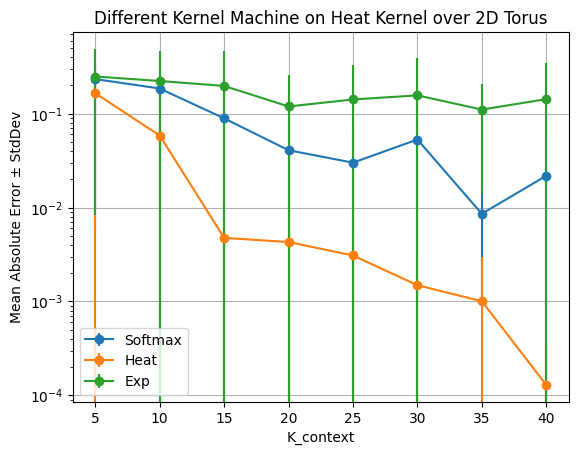

In [ ]:
for model in models.keys():
    means = means_for_models[model]

    stds = stds_for_models[model]
    print(f'{model=} {list(zip(context_lengths,means))=}')
    plt.errorbar(context_lengths, means, yerr=stds, fmt='-o', label=model.capitalize())
plt.xlabel('K_context')
plt.ylabel('Mean Absolute Error ± StdDev')
plt.yscale('log')
plt.title('Different Kernel Machine on Heat Kernel over 2D Torus')
plt.xticks(context_lengths)
plt.grid(True)
plt.legend()
plt.show()  

In [ ]:

for tracker, n in zip(trackers, context_lengths):
    print(f'{n=}')
    for model in tracker.best.keys():
        print(f'{model=}')
        print(tracker.best[model])

n=np.int64(5)
model='softmax'
{'t': 0.5, 'lam': 1e-08, 'score': np.float64(1.029845081208265), 'context_length': np.int64(5)}
model='heat'
{'t': 0.5, 'lam': 1e-08, 'score': np.float64(1.1511650171837535), 'context_length': np.int64(5)}
model='exp'
{'t': 0.5, 'lam': 1e-08, 'score': np.float64(0.9984639701854825), 'context_length': np.int64(5)}
n=np.int64(10)
model='softmax'
{'t': 0.5, 'lam': 1e-08, 'score': np.float64(1.0279762068022715), 'context_length': np.int64(10)}
model='heat'
{'t': 0.5, 'lam': 1e-08, 'score': np.float64(1.0389433484742632), 'context_length': np.int64(10)}
model='exp'
{'t': 0.5, 'lam': 1e-08, 'score': np.float64(0.997440746224719), 'context_length': np.int64(10)}
n=np.int64(15)
model='softmax'
{'t': 0.5, 'lam': 1e-08, 'score': np.float64(0.9401124957864005), 'context_length': np.int64(15)}
model='heat'
{'t': 0.5, 'lam': 1e-08, 'score': np.float64(1.0304044093211617), 'context_length': np.int64(15)}
model='exp'
{'t': 0.5, 'lam': 1e-08, 'score': np.float64(0.9622880